### DPCN Team Baby Sharks Project
- Amey Choudhary
- Aryan Gupta
- Keshav Gupta

# MODWT

In [152]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as  nn
import torch.optim as optim
import torch
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

In [153]:
# Selecting the dataset. Change the file path and type of data (Manual)
file_path ="./Datasets/Malaria_datasets/Venezuela_Malaria.xlsx"

# Reading the data
dataset = pd.read_excel(file_path)

print("The shape of the dataset: ", dataset.shape)
print("The first 5 entries are:" )
print(dataset.head())


The shape of the dataset:  (669, 2)
The first 5 entries are:
   Weeks  Cases
0      1    588
1      2    635
2      3    405
3      4    425
4      5    452


In [154]:
location = file_path.split("/")[-1].split("_")[0]
disease = file_path.split("/")[-1].split("_")[1].split(".")[0]

# selecting the hyperparameters for the dataset from excel
hyperparameters = pd.read_excel("./Suggested hyper-parameter values of EWNet model.xlsx")

# finding the hyperparameters for the dataset
for i in range(hyperparameters.shape[0]):
    name = hyperparameters.iloc[i, 0]
    loc = name.split(" ")[0]
    dis = name.split(" ")[1]
    if loc == location and dis == disease:
        hyperparameters_index = i
        break

# type of dataset as in weekly or monthly. need to set this manual after looking at the dataset values
type_of_dataset = "Weekly" # "Weekly" or "Monthly

# select the index of time , manual
index_of_cases = 1

# select the forecast type manually
forecast_type = "Medium" # "Short" or "Medium" or "Long"

p = hyperparameters[forecast_type][hyperparameters_index]
k = (p+1)//2

pred_length_weekly = {"Short": 13, "Medium": 26, "Long": 52}
pred_length_monthly = {"Short": 3, "Medium": 6, "Long": 12}

if type_of_dataset == "Weekly":
    pred_length = pred_length_weekly[forecast_type]
else:
    pred_length = pred_length_monthly[forecast_type]

test_size = pred_length
valid_size = 2*pred_length
train_size = dataset.shape[0] - test_size - valid_size-p # p is the lag, so train size wont contain the first p values


print("The value of p:",p)
print("The value of k:", k)
print("The prediction length is:", pred_length)



The value of p: 12
The value of k: 6
The prediction length is: 26


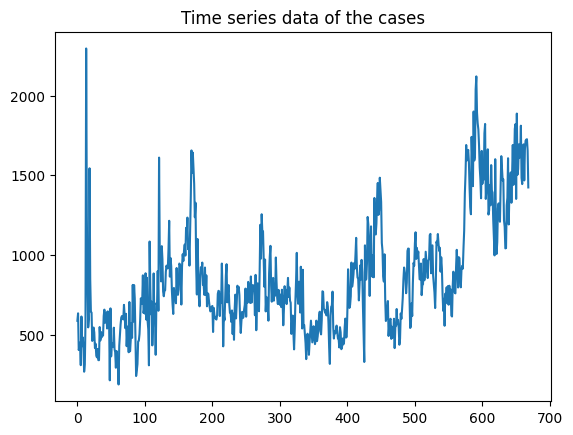

In [155]:
# changing to time series data
cases_time_series = dataset.iloc[:, index_of_cases].values
plt.plot(cases_time_series)
plt.title("Time series data of the cases")
plt.show()

In [156]:
import numpy as np
import pdb
import pywt
from scipy.ndimage import convolve1d

# def circular_convolve_d(h_t, v_j_1, j):
#     N = len(v_j_1)
#     w_j = np.zeros(N)
#     ker = np.zeros(len(h_t) * 2**(j - 1))

#     # make kernel
#     for i, h in enumerate(h_t):
#         ker[i * 2**(j - 1)] = h
    
#     w_j = convolve1d(v_j_1, ker, mode="wrap", origin=-(len(ker) // 2))
#     return w_j


# def circular_convolve_s(h_t, g_t, w_j, v_j, j):
#     N = len(v_j)

#     h_ker = np.zeros(len(h_t) * 2**(j - 1))
#     g_ker = np.zeros(len(g_t) * 2**(j - 1))

#     for i, (h, g) in enumerate(zip(h_t, g_t)):
#         h_ker[i * 2**(j - 1)] = h
#         g_ker[i * 2**(j - 1)] = g

#     v_j_1 = np.zeros(N)

#     v_j_1 = convolve1d(w_j,
#                        np.flip(h_ker),
#                        mode="wrap",
#                        origin=(len(h_ker) - 1) // 2)
#     v_j_1 += convolve1d(v_j,
#                         np.flip(g_ker),
#                         mode="wrap",
#                         origin=(len(g_ker) - 1) // 2)
#     return v_j_1


def circular_convolve_d(h_t, v_j_1, j):
    '''
    jth level decomposition
    h_t: \tilde{h} = h / sqrt(2)
    v_j_1: v_{j-1}, the (j-1)th scale coefficients
    return: w_j (or v_j)
    '''
    N = len(v_j_1)
    L = len(h_t)
    w_j = np.zeros(N)
    l = np.arange(L)
    for t in range(N):
        index = np.mod(t - 2 ** (j - 1) * l, N)
        v_p = np.array([v_j_1[ind] for ind in index])
        w_j[t] = (np.array(h_t) * v_p).sum()
    return w_j


def circular_convolve_s(h_t, g_t, w_j, v_j, j):
    '''
    (j-1)th level synthesis from w_j, w_j
    see function circular_convolve_d
    '''
    N = len(v_j)
    L = len(h_t)
    v_j_1 = np.zeros(N)
    l = np.arange(L)
    for t in range(N):
        index = np.mod(t + 2 ** (j - 1) * l, N)
        w_p = np.array([w_j[ind] for ind in index])
        v_p = np.array([v_j[ind] for ind in index])
        v_j_1[t] = (np.array(h_t) * w_p).sum()
        v_j_1[t] = v_j_1[t] + (np.array(g_t) * v_p).sum()
    return v_j_1


def modwt(x, filters, level):
    # filter
    wavelet = pywt.Wavelet(filters)

    h = wavelet.dec_hi
    g = wavelet.dec_lo
    h_t = np.array(h) / np.sqrt(2)
    g_t = np.array(g) / np.sqrt(2)
    wavecoeff = []
    v_j_1 = x
    for j in range(level):
        w = circular_convolve_d(h_t, v_j_1, j + 1)
        v_j_1 = circular_convolve_d(g_t, v_j_1, j + 1)
        wavecoeff.append(w)
    wavecoeff.append(v_j_1)
    return np.vstack(wavecoeff)

def imodwt(w, filters):
    # filter
    wavelet = pywt.Wavelet(filters)
    h = wavelet.dec_hi
    g = wavelet.dec_lo
    h_t = np.array(h) / np.sqrt(2)
    g_t = np.array(g) / np.sqrt(2)
    level = len(w) - 1
    v_j = w[-1]
    for jp in range(level):
        j = level - jp - 1
        v_j = circular_convolve_s(h_t, g_t, w[j], v_j, j + 1)
    return v_j


In [157]:
cases_time_series_pruned = cases_time_series[0:train_size+valid_size+p]

# scaling the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
cases_time_series_scaled = scaler.fit_transform(cases_time_series_pruned.reshape(-1, 1)).reshape(-1)


In [158]:
# from ..modwt import modwt, imodwt
n = np.floor(np.log(len(cases_time_series_scaled))).astype(int)
filter_m = 'haar'
IMFs = modwt(cases_time_series_scaled, filter_m, n)
IMFs = np.array(IMFs)
n_imfs = IMFs.shape[0]

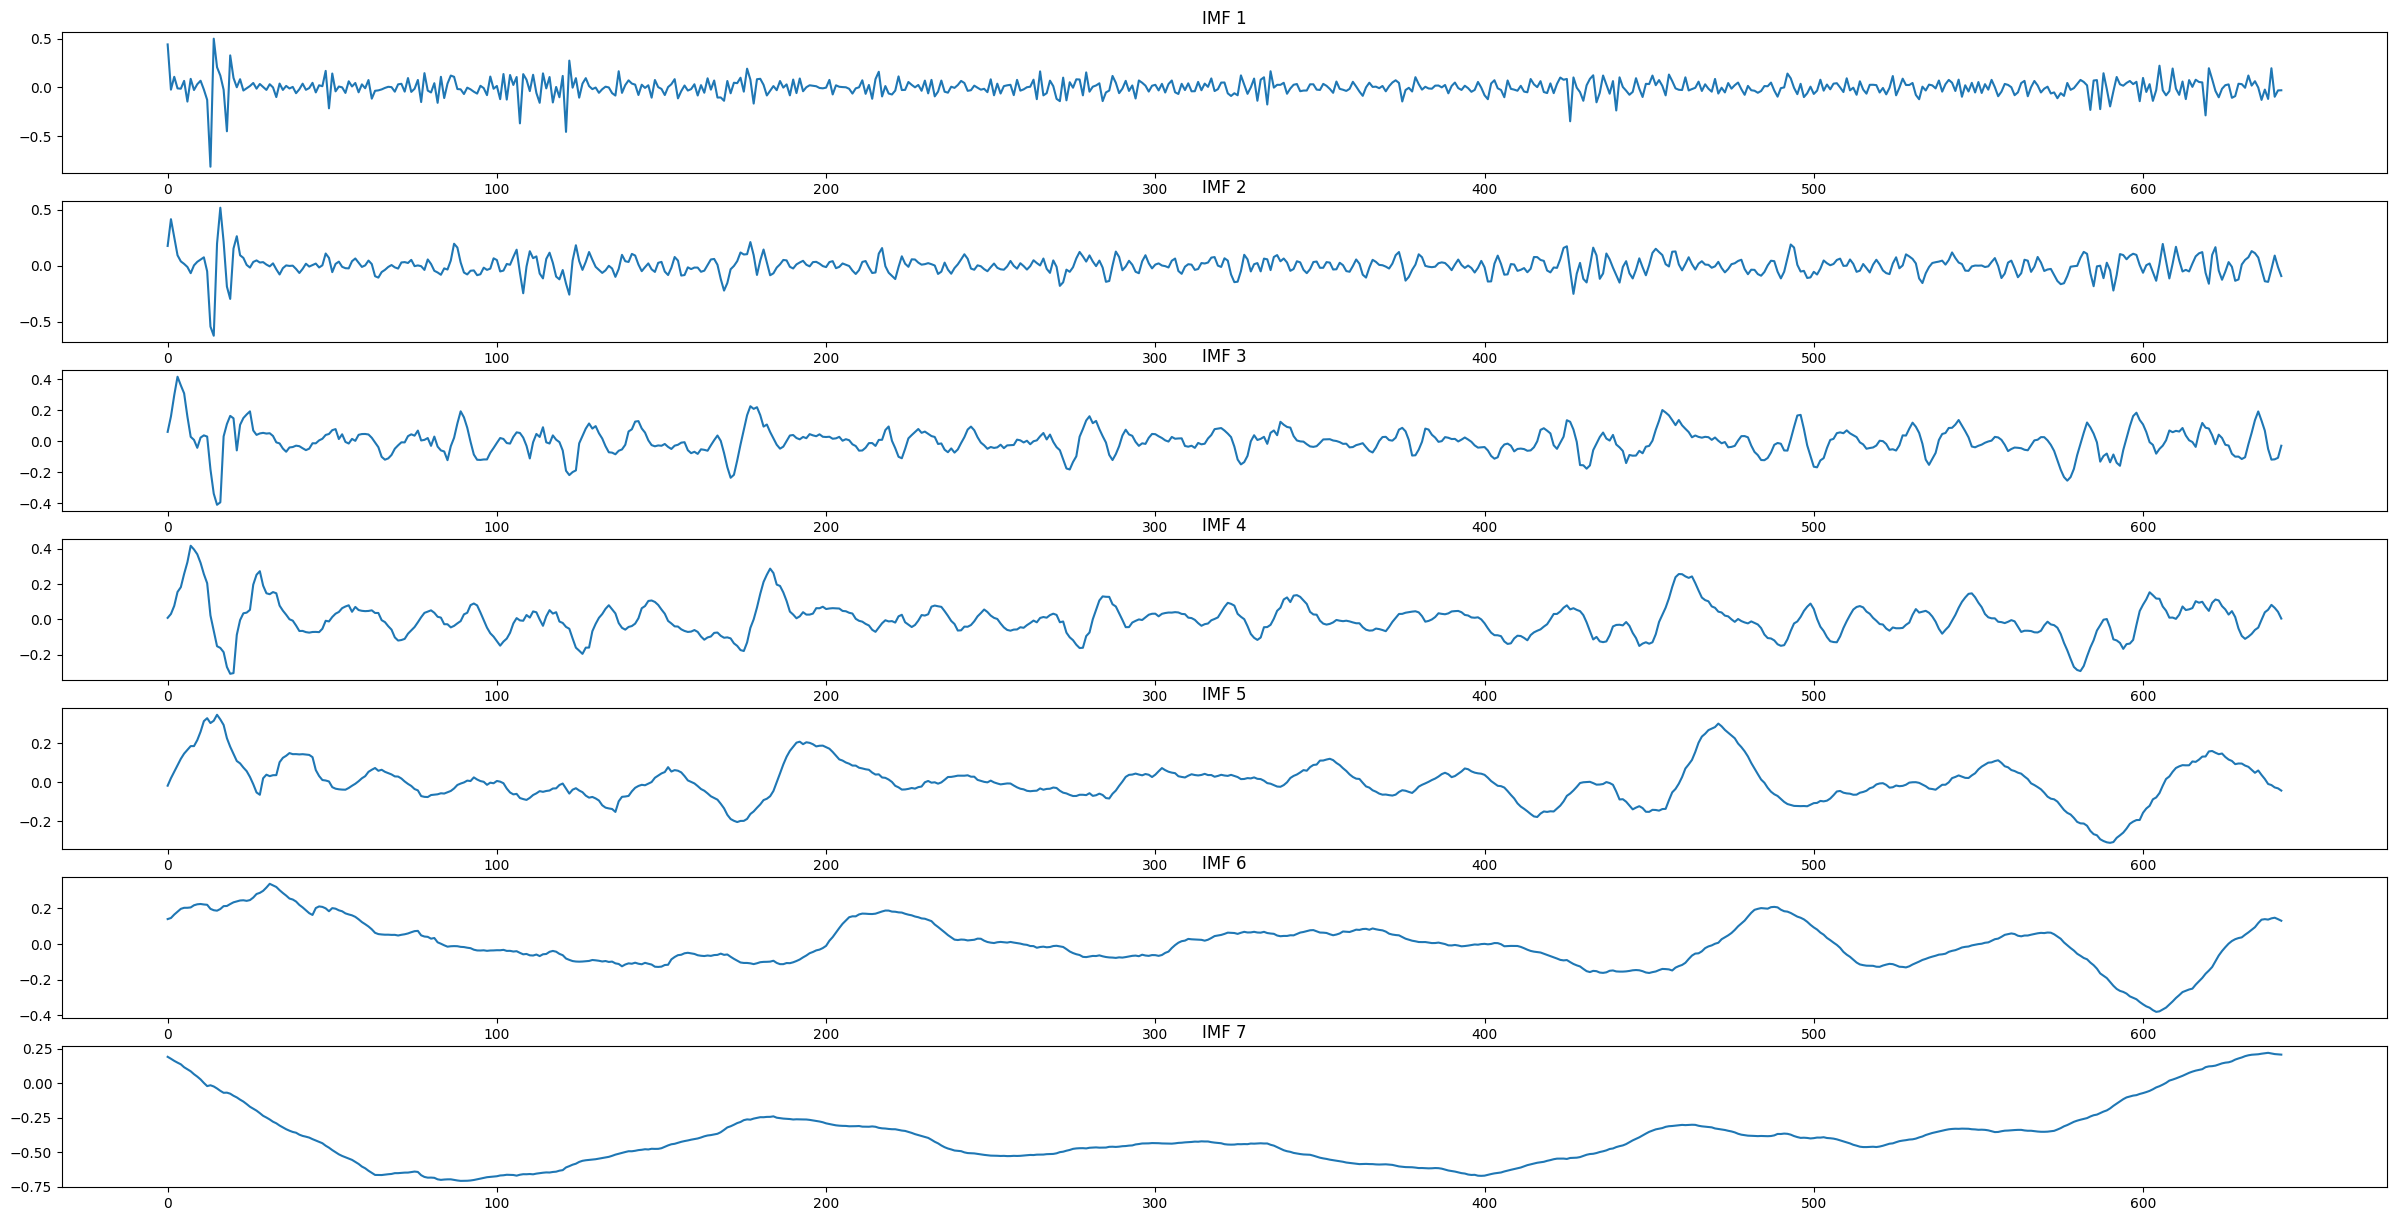

In [159]:
# plotting the IMFs
plt.figure(figsize=(30, 15))
for i in range(n_imfs):
    plt.subplot(n_imfs, 1, i+1)
    plt.plot(IMFs[i])
    plt.title("IMF "+str(i+1))
plt.show()


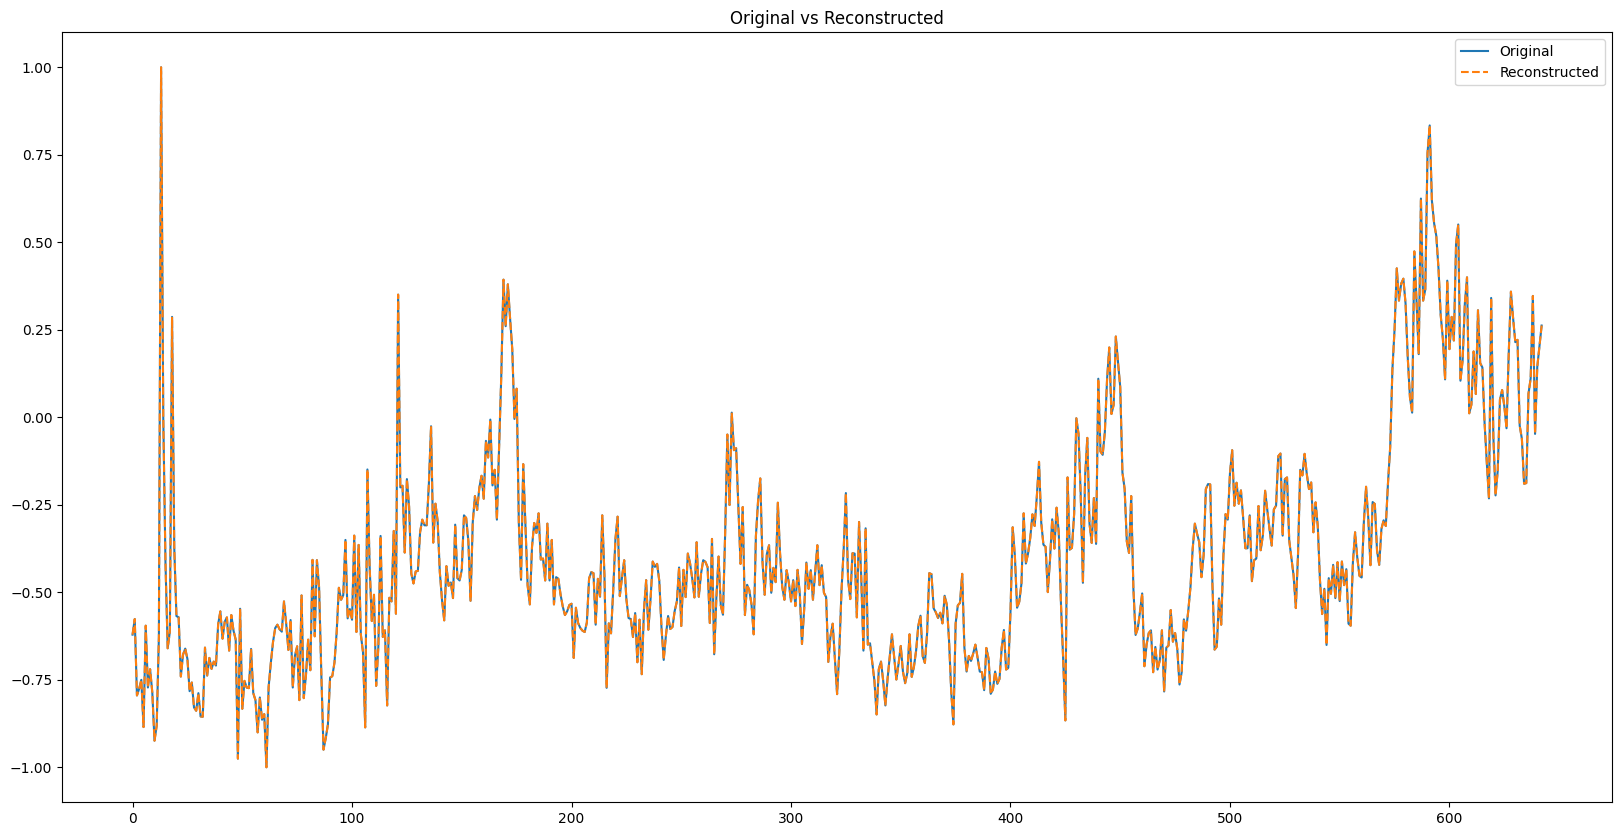

In [160]:
# checking the IMFs and actual
reconstructed_time_series = imodwt(IMFs, filter_m)
plt.figure(figsize=(20, 10))
plt.plot(cases_time_series_scaled, label="Original" )
plt.plot(reconstructed_time_series, label="Reconstructed", linestyle="--")
plt.title("Original vs Reconstructed")
plt.legend()
plt.show()

clearly the decomposition is done well

In [161]:
# creating the class for neural network
class EWNet(nn.Module):
    def __init__(self, p, k):
        super(EWNet, self).__init__()
        self.fc1 = nn.Linear(p, k)
        self.fc2 = nn.Linear(k, 1)
        self.act = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x


In [162]:
# creating the train dataset and test dataset

# Define function to create lagged sequences
def create_lagged_sequence(data, lag):
    X, y = [], []
    for i in range(len(data)-lag):
        X.append(data[i:(i+lag)])
        y.append(data[i+lag])
    return np.array(X), np.array(y)



X_train = []
y_train = []
X_valid = []
y_valid = []

for i in range(n_imfs):
    X, y = create_lagged_sequence(IMFs[i], p)
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)
    X_train.append(X[0:train_size])
    y_train.append(y[0:train_size])
    X_valid.append(X[train_size:train_size+valid_size])
    y_valid.append(y[train_size:train_size+valid_size])

In [163]:
print("The shape of X_train[0]:", X_train[0].shape)
print("The shape of y_train[0]:", y_train[0].shape)
print("The shape of X_valid[0]:", X_valid[0].shape)
print("The shape of y_valid[0]:", y_valid[0].shape)

The shape of X_train[0]: torch.Size([579, 12])
The shape of y_train[0]: torch.Size([579])
The shape of X_valid[0]: torch.Size([52, 12])
The shape of y_valid[0]: torch.Size([52])


Training started for model:  1
Epoch:  0 Training Loss:  0.18556123971939087 Validation Loss:  0.18873471021652222
Epoch:  1000 Training Loss:  0.006415599957108498 Validation Loss:  0.007632085122168064
Epoch:  2000 Training Loss:  0.006209214683622122 Validation Loss:  0.007334359455853701
Epoch:  3000 Training Loss:  0.0061371163465082645 Validation Loss:  0.007162480615079403
Epoch:  4000 Training Loss:  0.006033026613295078 Validation Loss:  0.007130674552172422
Epoch:  5000 Training Loss:  0.005897147115319967 Validation Loss:  0.007231248542666435
Epoch:  6000 Training Loss:  0.0056529599241912365 Validation Loss:  0.007685687858611345
Epoch:  7000 Training Loss:  0.005345894023776054 Validation Loss:  0.008532031439244747
Epoch:  8000 Training Loss:  0.0050973123870790005 Validation Loss:  0.010018039494752884
Epoch:  9000 Training Loss:  0.004906987305730581 Validation Loss:  0.011846826411783695
Training completed for model:  1
Training started for model:  2
Epoch:  0 Trainin

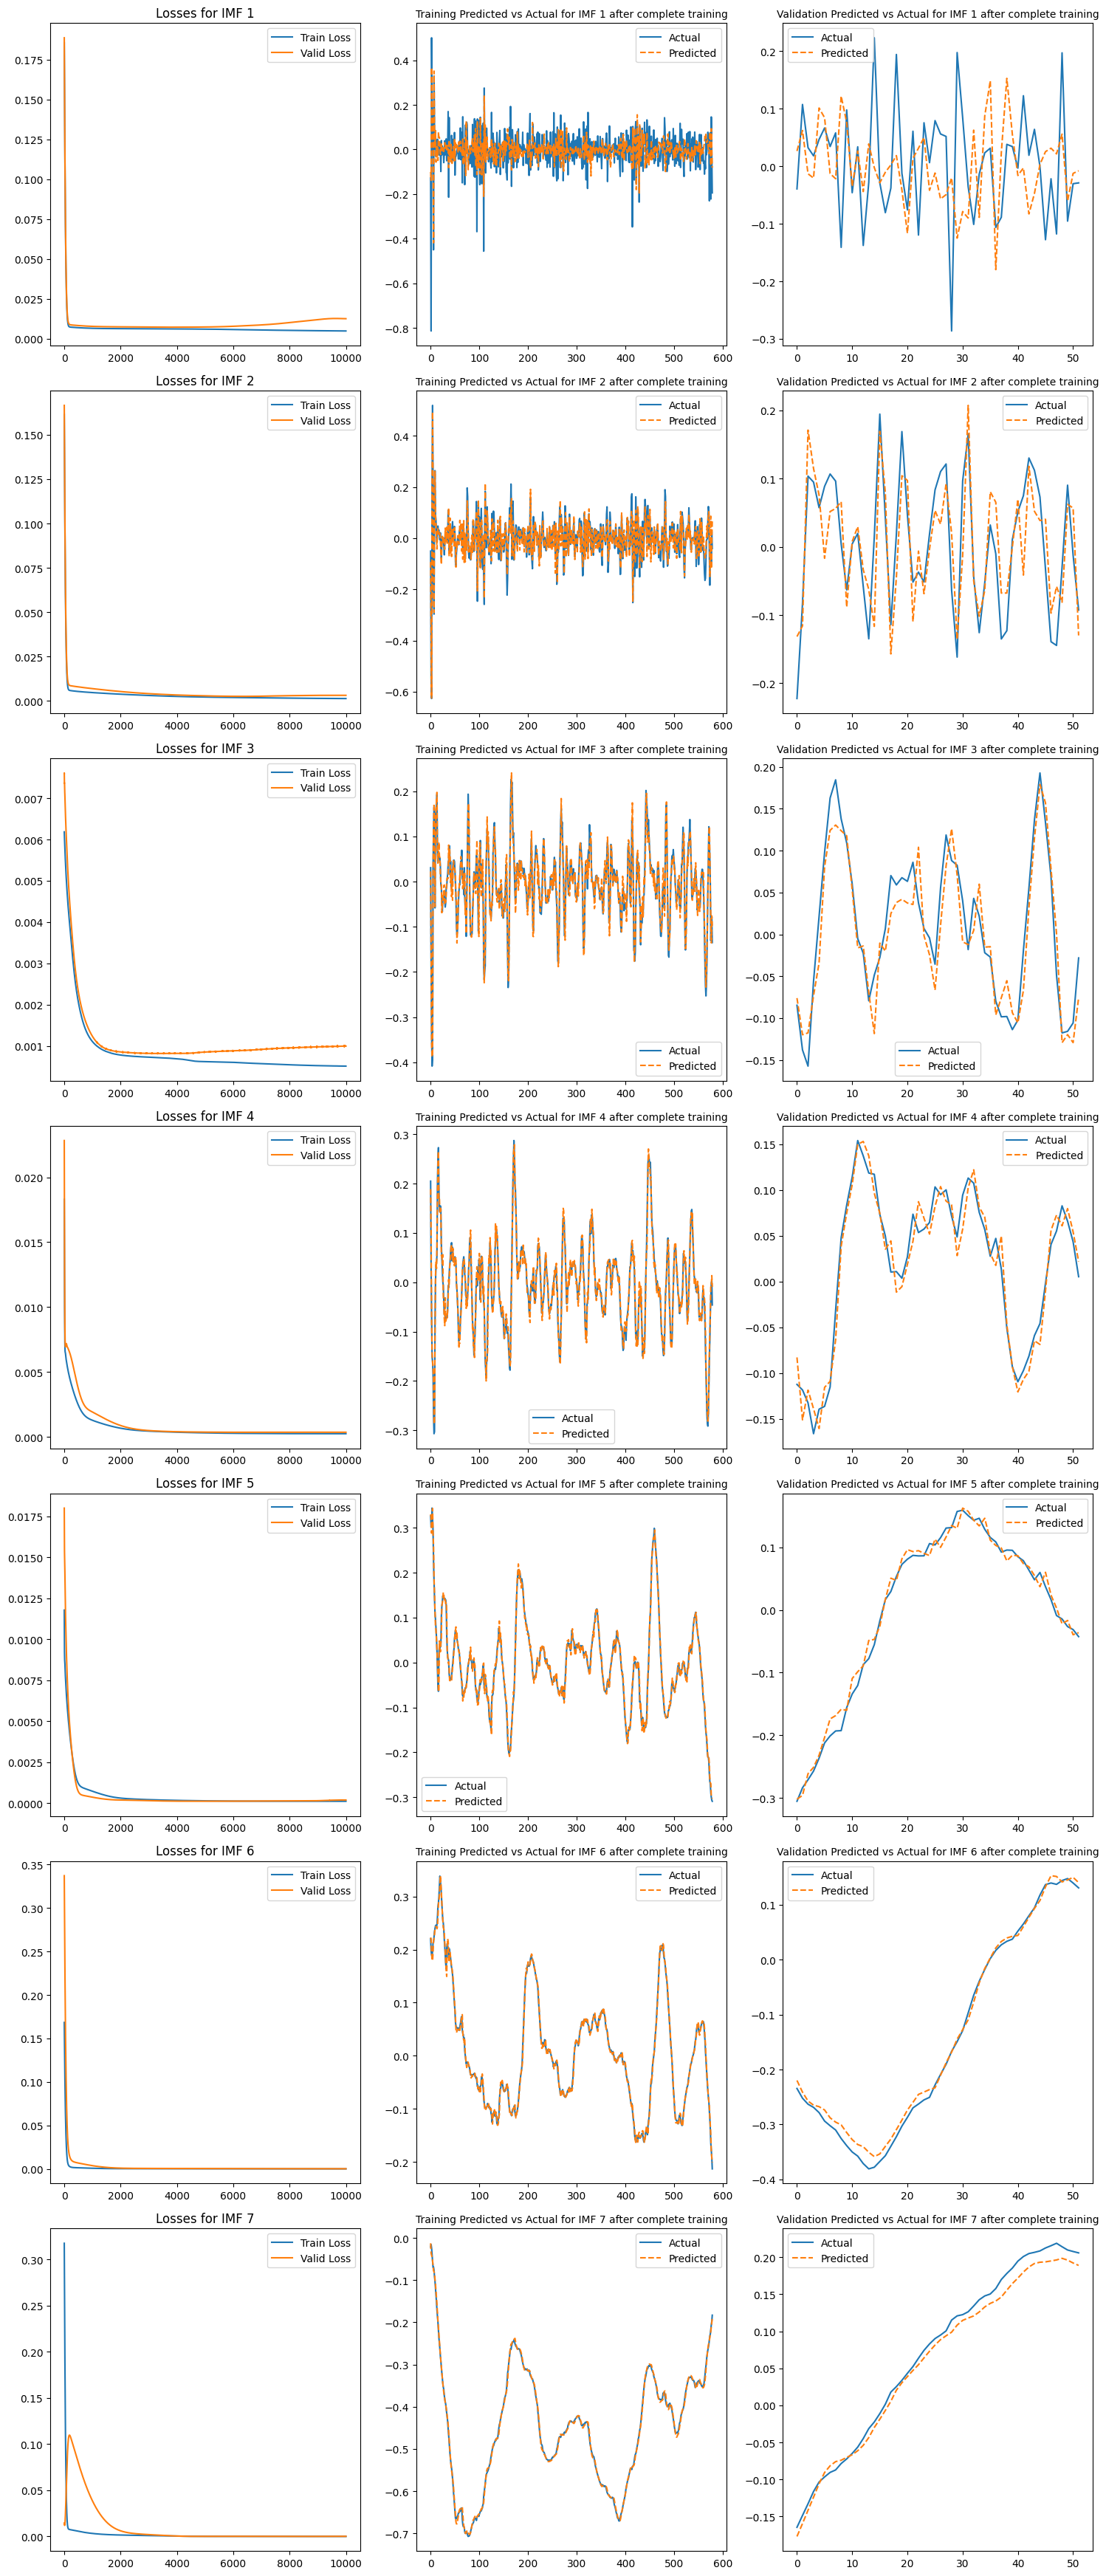

In [164]:
# running the model
n_models = []
fig, axes = plt.subplots(n_imfs, 3, figsize=(15, 5*n_imfs))

for i in range(n_imfs):
    # initializing the model
    model = EWNet(p, k)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epochs = 10000
    print_freq = 10
    epoch_freq = epochs//print_freq
    train_losses = []
    valid_losses = []

    print("Training started for model: ", i+1)
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        y_train_pred = model(X_train[i])
        y_train_pred = y_train_pred.view(-1)
        loss = criterion(y_train_pred, y_train[i])
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        with torch.no_grad():
            model.eval()
            y_valid_pred = model(X_valid[i])
            y_valid_pred = y_valid_pred.view(-1)
            valid_loss = criterion(y_valid_pred, y_valid[i])
            valid_losses.append(valid_loss.item())
        if epoch % epoch_freq == 0:
            print("Epoch: ", epoch, "Training Loss: ", loss.item(), "Validation Loss: ", valid_loss.item())
    print("Training completed for model: ", i+1)

    # Saving the model
    n_models.append(model)

    # Plot training and validation losses
    axes[i, 0].plot(train_losses, label="Train Loss")
    axes[i, 0].plot(valid_losses, label="Valid Loss")
    axes[i, 0].set_title("Losses for IMF "+str(i+1))
    axes[i, 0].legend()

    # Plotting the predicted vs actual for training
    axes[i, 1].plot(y_train[i], label="Actual")
    axes[i, 1].plot(y_train_pred.detach().numpy(), label="Predicted", linestyle="--")
    axes[i, 1].set_title("Training Predicted vs Actual for IMF "+str(i+1) + " after complete training" , fontsize=10)
    axes[i, 1].legend()

    # Plotting the predicted vs actual for validation
    axes[i, 2].plot(y_valid[i], label="Actual")
    axes[i, 2].plot(y_valid_pred.detach().numpy(), label="Predicted", linestyle="--")
    axes[i, 2].set_title("Validation Predicted vs Actual for IMF "+str(i+1) + " after complete training", fontsize=10)
    axes[i, 2].legend()

plt.tight_layout()
plt.show()


In [165]:
# testing the models
y_test_pred_final = []

for i in range(n_imfs):
    initial_input = IMFs[i][ -p:]
    y_test_pred_imfs = []
    model = n_models[i]
    model.eval()    
    with torch.no_grad():
        for j in range(test_size):
            y_pred = model(torch.tensor(initial_input[-p:], dtype=torch.float32))
            y_test_pred_imfs.append(y_pred.item())
            initial_input = np.append(initial_input, y_pred.item())
    y_test_pred_final.append(y_test_pred_imfs)

In [166]:
y_test_pred_final = np.array(y_test_pred_final)
y_test_pred_final = imodwt(y_test_pred_final, filter_m)
y_test_pred_final = scaler.inverse_transform(y_test_pred_final.reshape(-1, 1)).reshape(-1)

The results are:
         RMSE         MAE      MASE      sMAPE
0  420.674186  390.839557  2.296894  27.228605


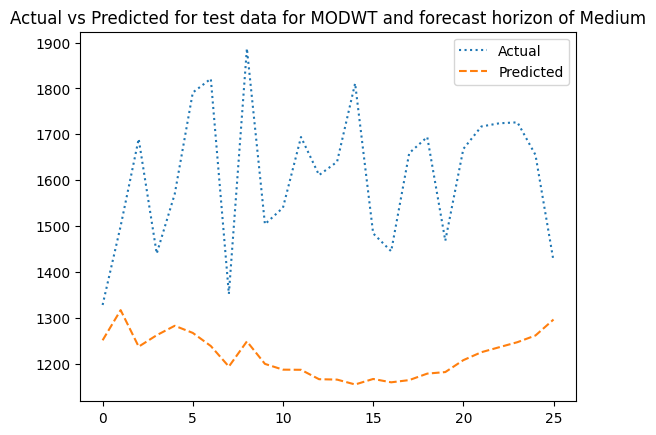

In [167]:
# calculating RMSE, MASE, MAE, sMAPE loss and  comparing the results
y_test_pred = np.array(y_test_pred_final)
y_test_true = np.array(cases_time_series[-test_size:])

rmse = np.sqrt(np.mean((y_test_pred - y_test_true)**2))
mae = np.mean(np.abs(y_test_pred - y_test_true))
mase = np.mean(np.abs(y_test_pred - y_test_true))/np.mean(np.abs(y_test_true[1:] - y_test_true[:-1]))
smape = 100*np.mean(2*np.abs(y_test_pred - y_test_true)/(np.abs(y_test_pred) + np.abs(y_test_true)))

# tabulate the results
results = pd.DataFrame({"RMSE": [rmse], "MAE": [mae], "MASE": [mase], "sMAPE": [smape]})
print("The results are:")
print(results)

plt.plot(y_test_true, label="Actual", linestyle= "dotted")
plt.plot(y_test_pred, label="Predicted", linestyle="--")
plt.title("Actual vs Predicted for test data for MODWT and forecast horizon of "+forecast_type)
plt.legend()
plt.show()